In [7]:
import pandas as pd
import numpy as np

from scipy.signal import welch

import matplotlib.pyplot as plt

import os
import re

In [8]:
# path to data directory
path_data = '..'

# for filtering, list of subject numbers in ### format (as strings)
subjects = None

# for filtering, list of dates in yyyy-mm-dd format
# this actually just restricts the subjects (files from other dates are still selected)
dates = ['2019-08-28']

In [9]:
def get_data_files(path_data, end='.csv'):
    
    # get folders
    date_folders = [f for f in os.listdir(path_data) if (os.path.isdir(os.path.join(path_data, f)) and re.match(r_date, f))]
    date_folders.sort()
    
    data = []

    for folder in date_folders:

        # get csv files from date folder
        files = [f for f in os.listdir(os.path.join(path_data, folder)) if f.endswith(end)]
        files.sort()

        for file in files:

            subject = re.match(r_subject, file).group()
            data.append({'subject':subject, 'date':folder, 'filename':file})
            
    # return dataframe
    return pd.DataFrame(data)

In [10]:
def plot_psd(axes, df, channels, labels):
    
    colors = {'Channel 1':'tab:gray', 'Channel 2':'tab:purple', 'Channel 3':'tab:blue', 'Channel 4':'tab:green',
              'Channel 5':'tab:olive', 'Channel 7':'tab:red', 'Channel 8':'tab:brown'}
    
    labels = list(labels)
    df = df[channels + ['Direction']]
    
    xlims = [5, 20]
    ylims = [0, 0]
    ncols = len(labels)
                
    for i_ax, ax in enumerate(axes):

        ax.set_title(labels[i_ax])
        ax.set_xlabel('Frequency (Hz)')
        ax.set_xlim(left=xlims[0], right=xlims[1])
        
        if i_ax == 0:
            ax.set_ylabel('Power (\u03BCV**2/Hz)')
        else:
            ax.set_yticklabels([])
        
        data = df[df['Direction']==labels[i_ax]].drop(columns='Direction')
        data = data.to_numpy().swapaxes(0, 1)
        
        # no rows with this label
        if data.shape[1] == 0:
            continue
        
        f, Pxx = welch(data, fs=256, nperseg=512, nfft=1024)
        
        id_freq = np.logical_and(f >= xlims[0], f <= xlims[1])
        
        f = f[id_freq]
        Pxx = Pxx[:, id_freq]

        legend = []
        for i_chan in range(len(channels)):
            if np.count_nonzero(Pxx[i_chan]):
                ax.plot(f, Pxx[i_chan], color=colors[channels[i_chan]])
                legend.append(channels[i_chan])
        
        ax.legend(legend)
        
        ylims[1] = max(ylims[1], ax.set_ylim()[1])
        
    for ax in axes:
        ax.set_ylim(bottom=ylims[0], top=min(ylims[1], 120))
    
    return

In [11]:
def get_trial_type_info(keys=None):
    
    info = {}
    
    info['types'] = ['mu', 'ssvep']
    info['labels'] = {'mu':['Rest', 'Left', 'Right'],
                  'ssvep':['RestSSVEP', 'Cue', '10Hz', '12Hz', '15Hz']}
    info['channels'] = {'mu':['Channel 1', 'Channel 2', 'Channel 7', 'Channel 8'],
                    'ssvep':['Channel 3', 'Channel 4', 'Channel 5']}
    
    if keys is None:
        keys = list(info.keys())
    
    return tuple([info[key] for key in keys])

Found 94 csv files in 15 date folders for 16 unique subjects.
Keeping 32 files after filtering for date(s) and subject(s).


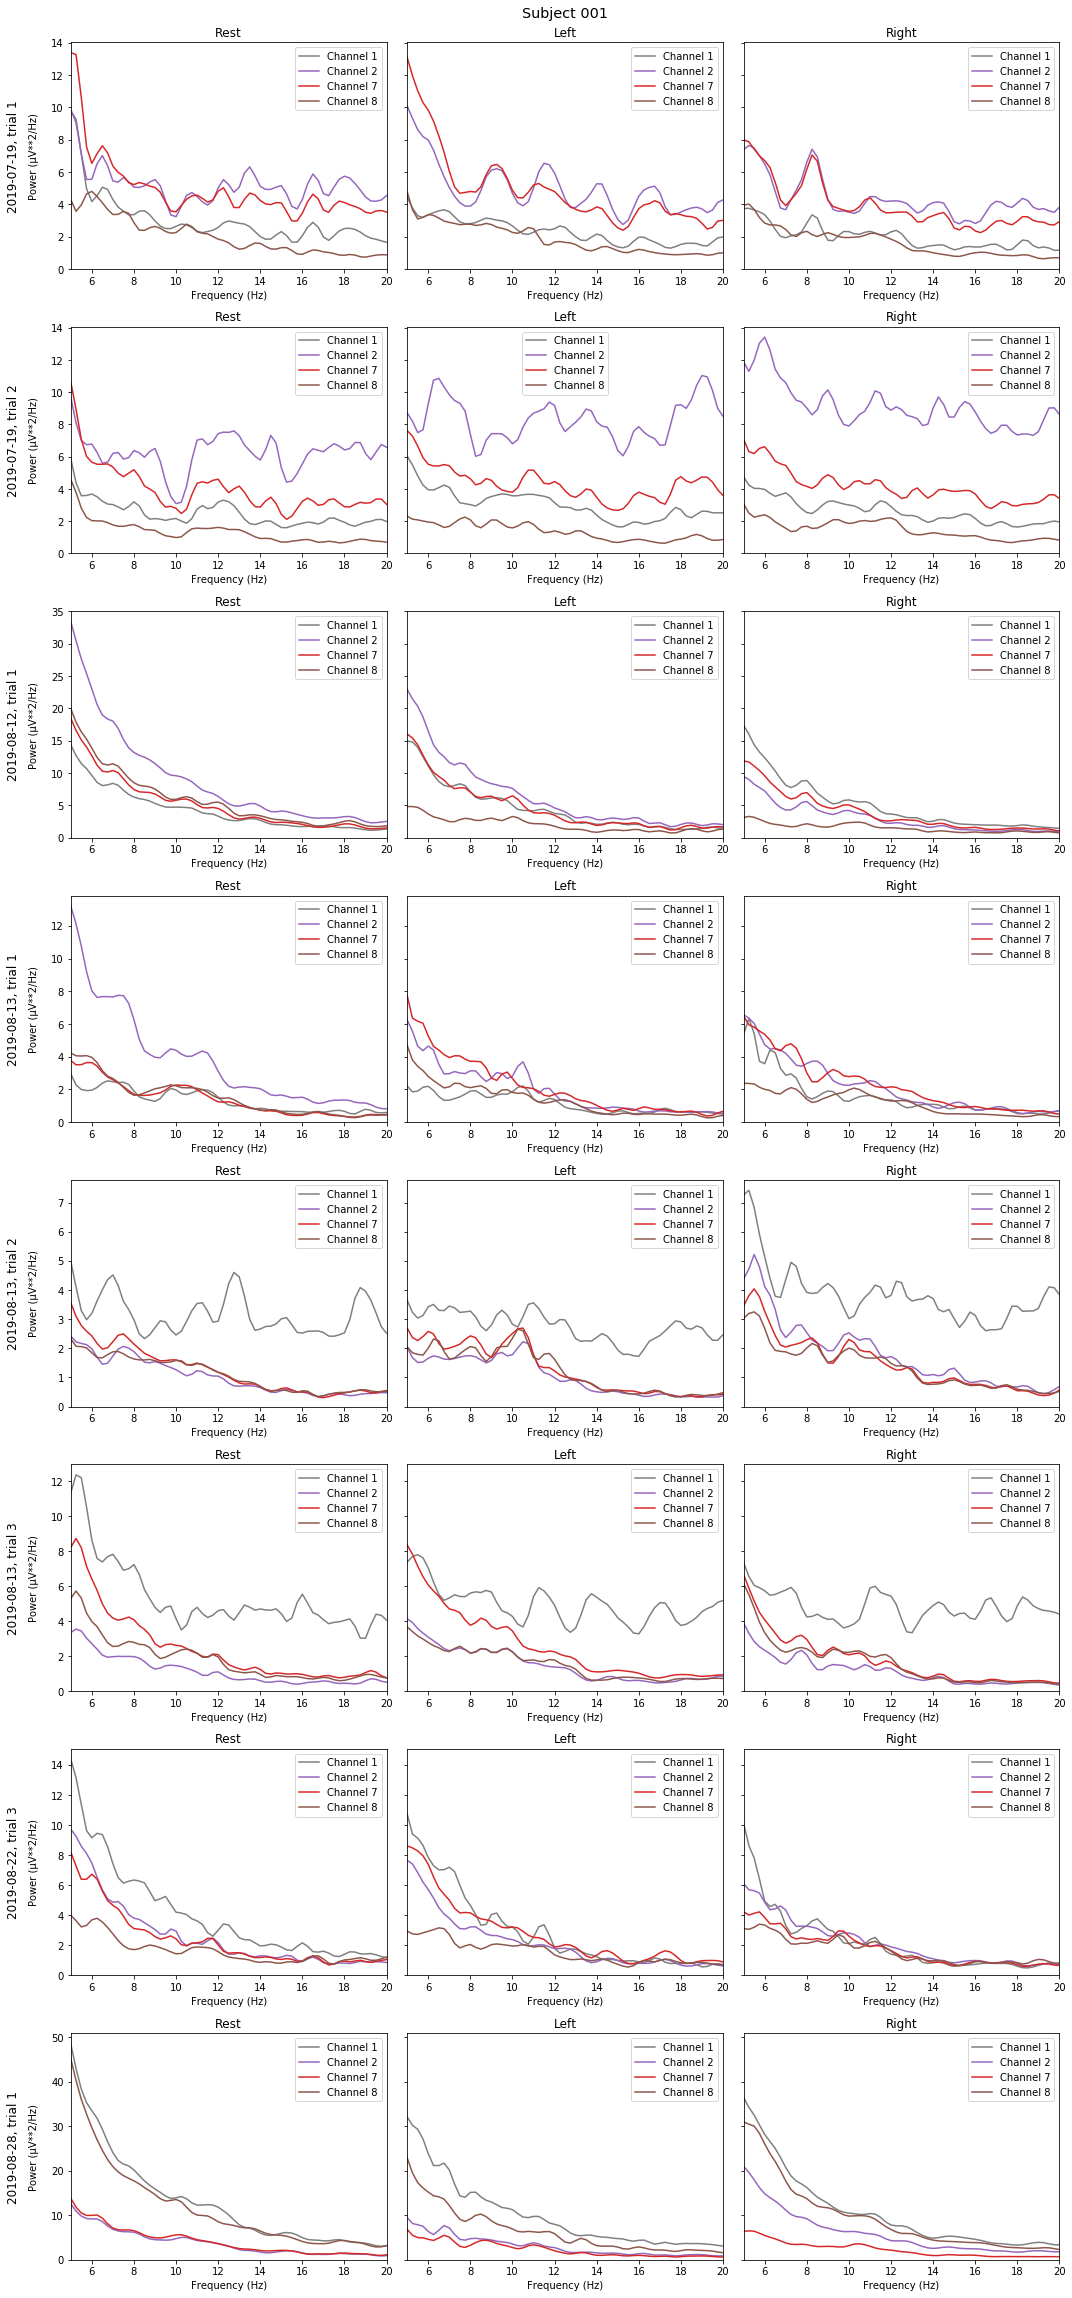

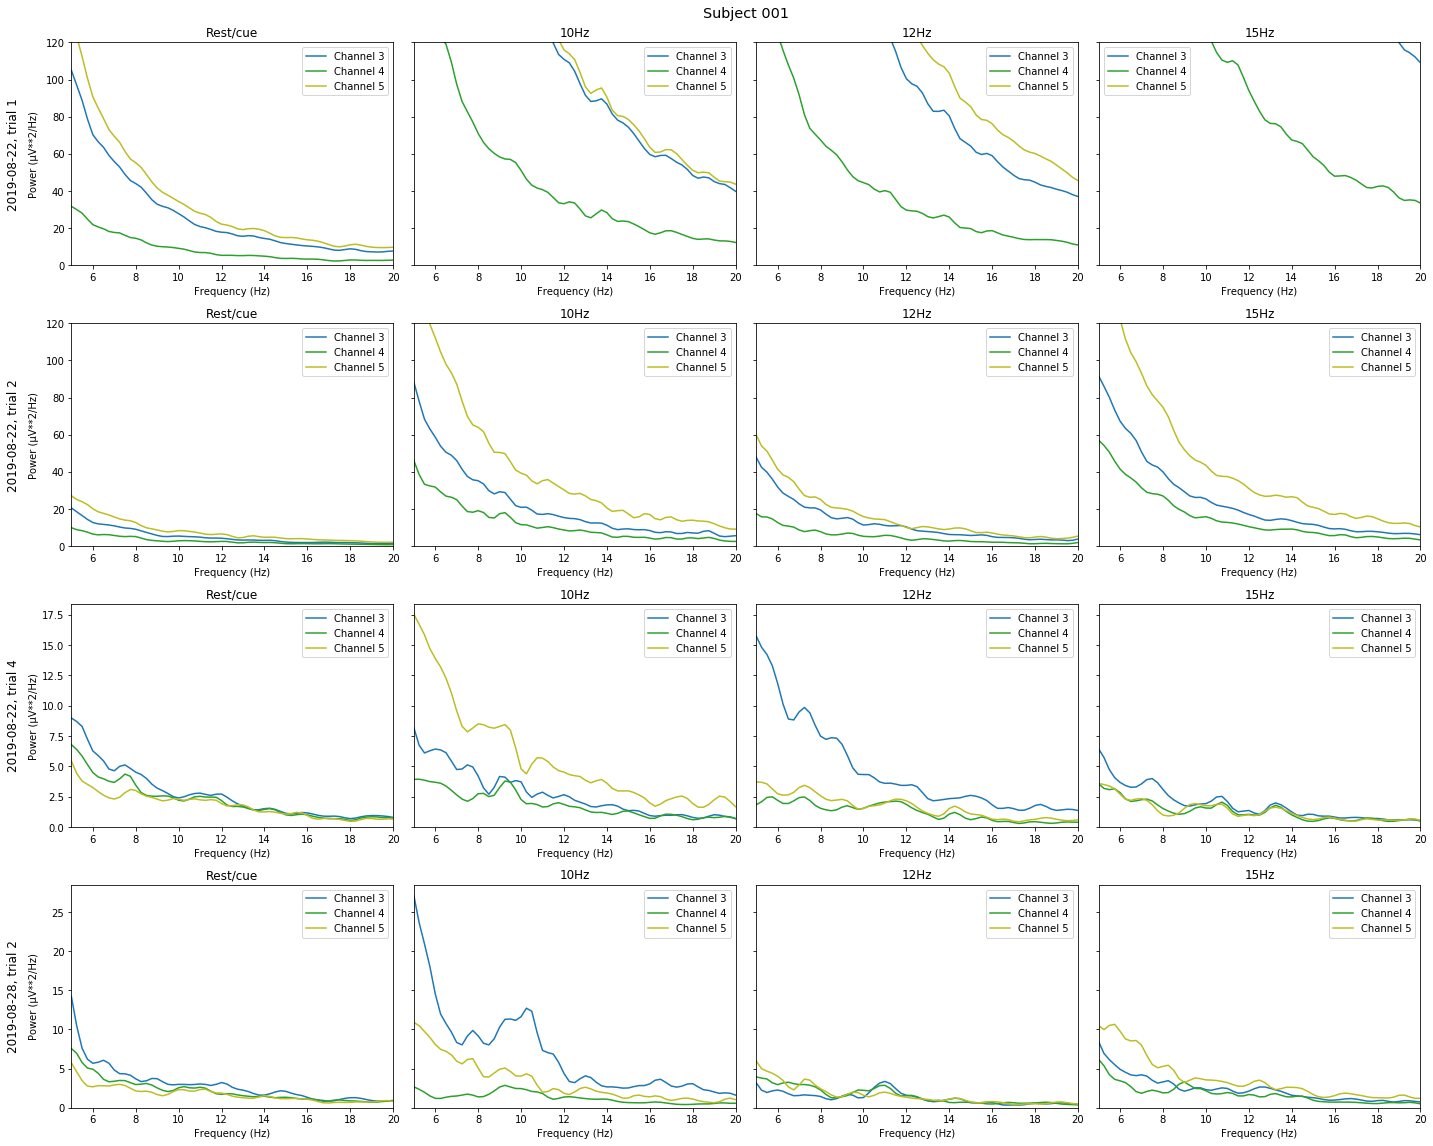

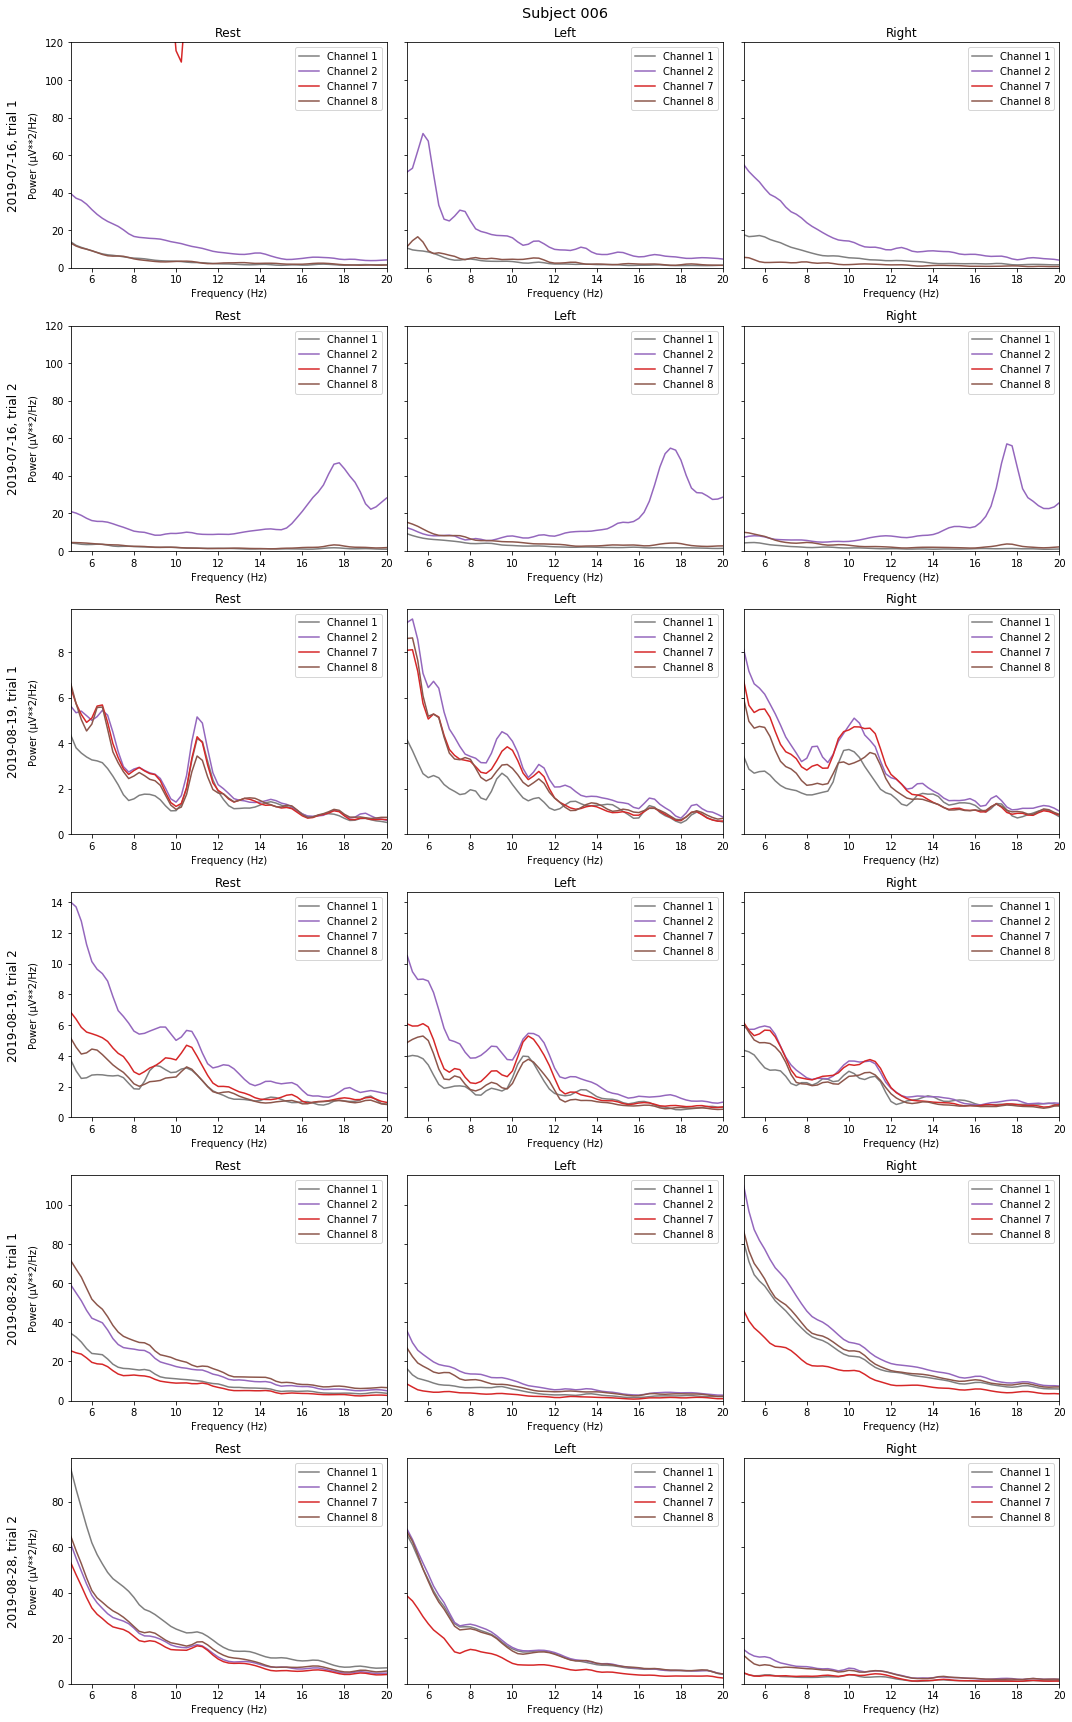

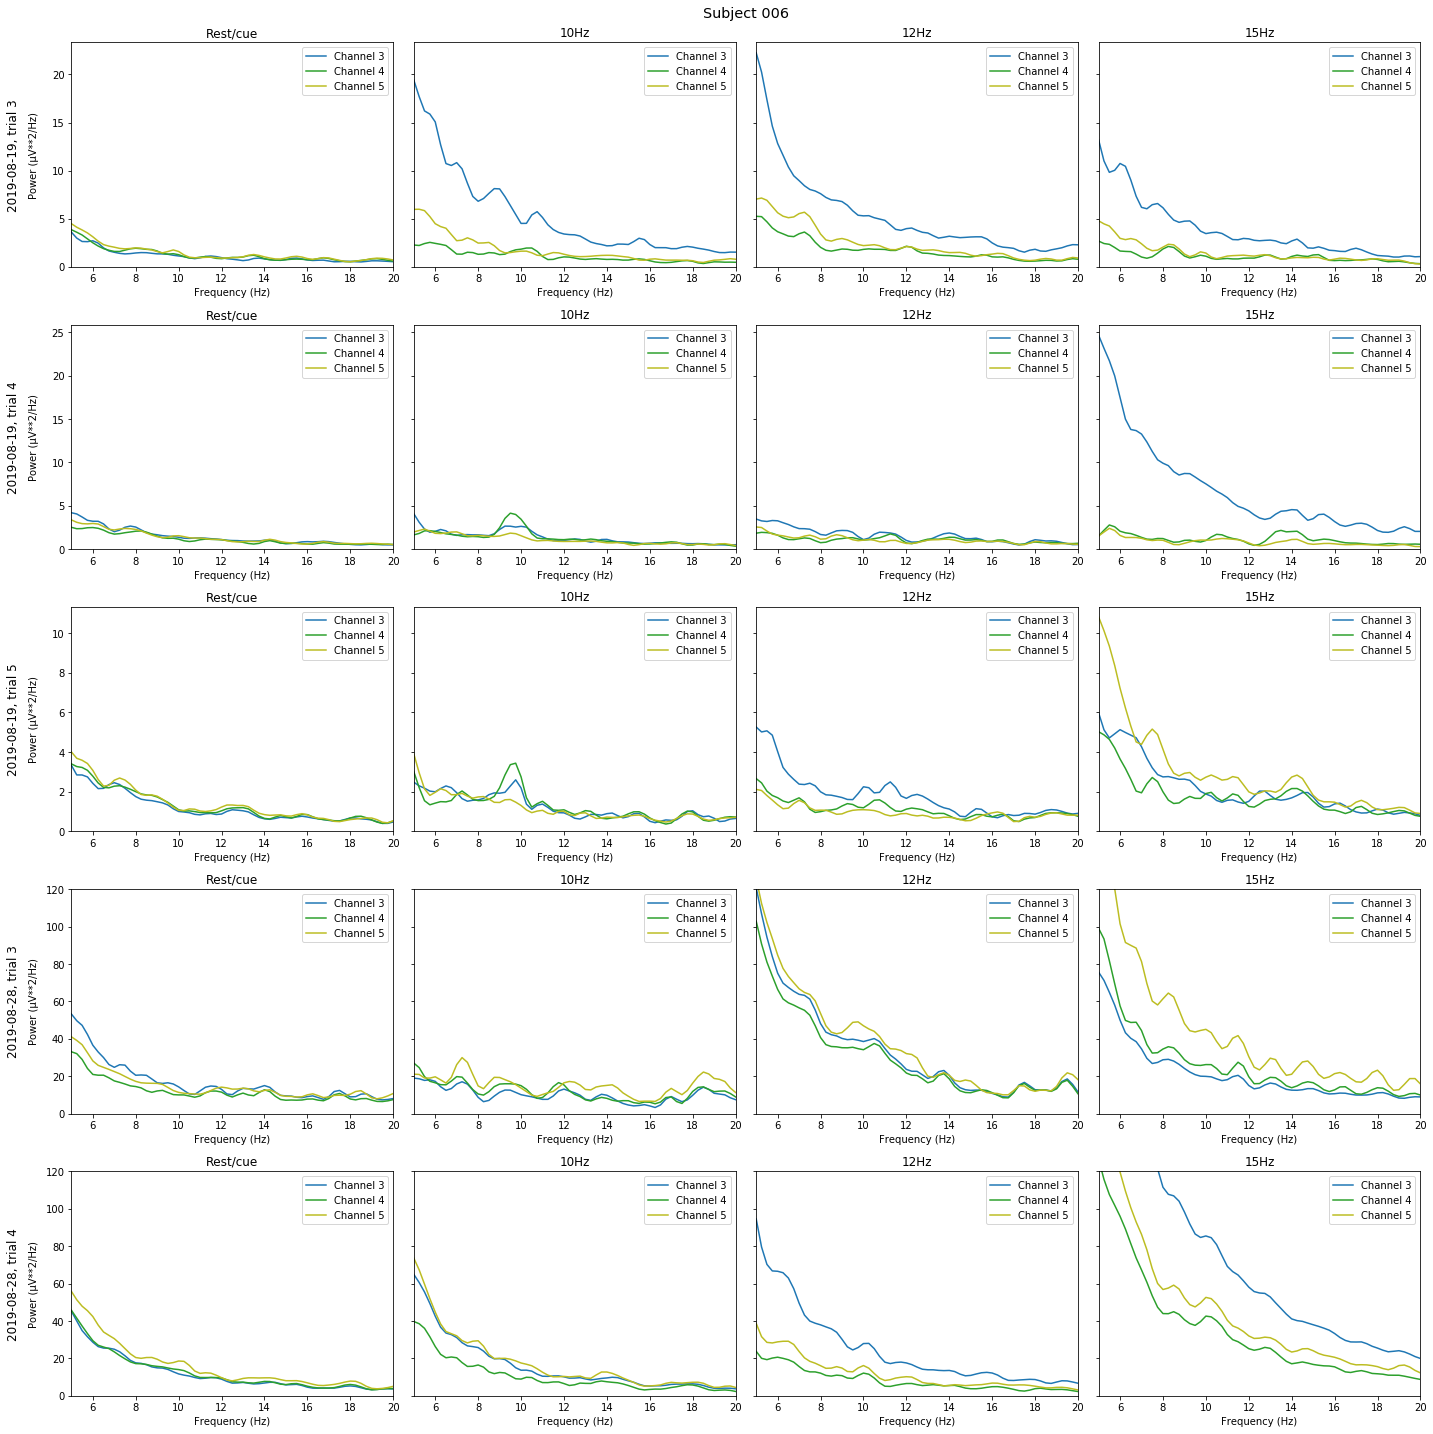

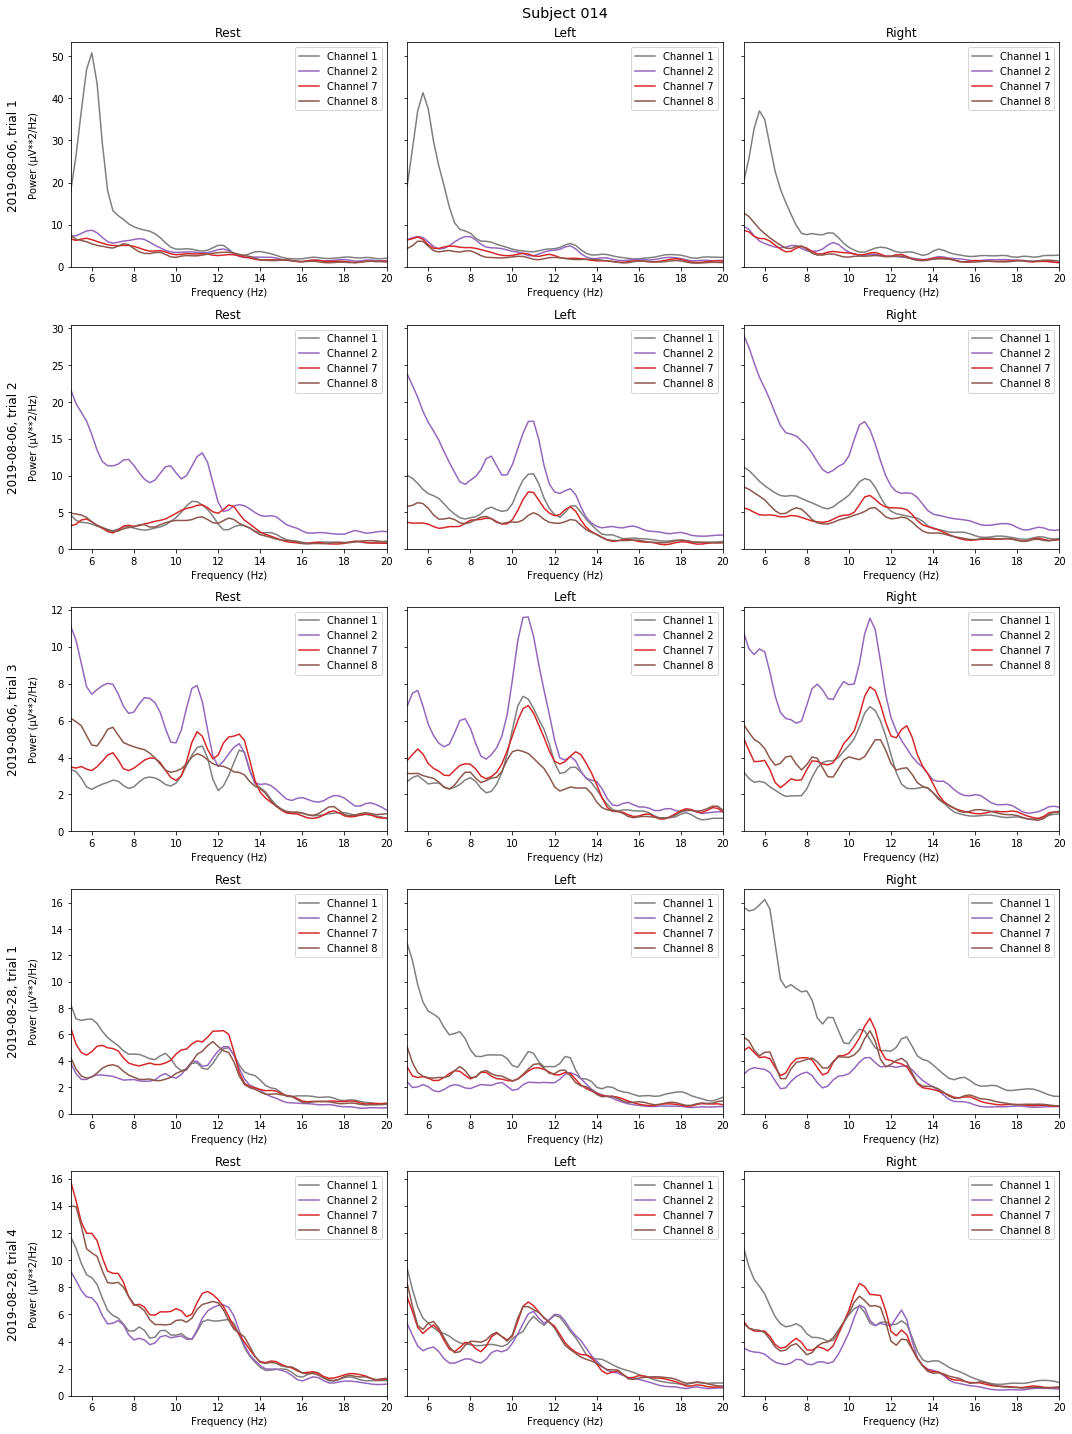

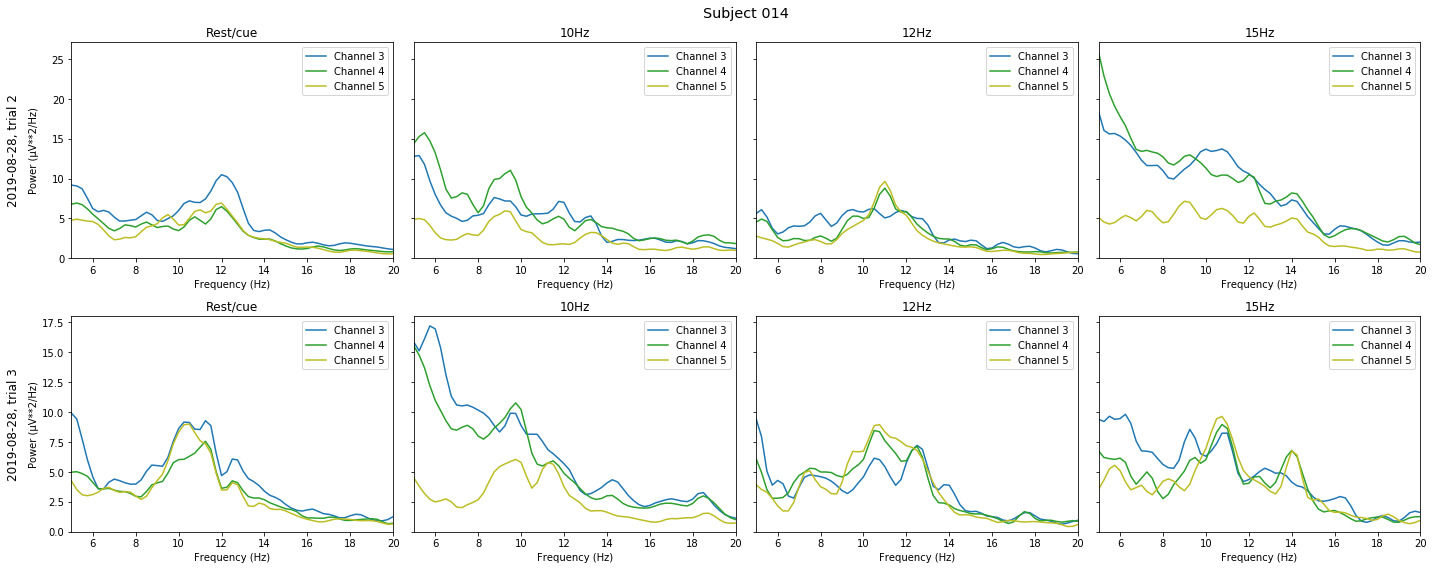

In [12]:
# set up regex
r_date = '\d{4}-\d{2}-\d{2}'
r_subject = '^\d{3}'
r_trial = '[tT]rial\d+'

# get labels and channels associated with each trial type 
trial_types, labels_all, channels_all = get_trial_type_info()

# get subject number, folder name and file name for each trial
df_files = get_data_files(path_data)

print('Found {} csv files in {} date folders for {} unique subjects.'.format(
    df_files.shape[0], len(df_files['date'].unique()), len(df_files['subject'].unique())))

# filter by subject(s) and/or date(s)
if dates is not None:
    subjects_dates = list(df_files.loc[df_files['date'].isin(dates)]['subject'].unique())
    if subjects is not None:
        subjects = [s for s in subjects if s in subjects_dates or subjects is None]
    else:
        subjects = subjects_dates

if subjects is not None:
    df_files = df_files.loc[df_files['subject'].isin(subjects)]

print('Keeping {} files after filtering for date(s) and subject(s).'.format(
    df_files.shape[0]))

# get subject numbers if no subject was specified
if subjects is None:
    subjects = df_files['subject'].unique()

# add a column for each possible trial type
for trial_type in trial_types:
    df_files[trial_type] = False

# for each trial
for (index, trial) in df_files.iterrows():

    # get all labels used in trial
    df_trial = pd.read_csv(os.path.join(path_data, trial['date'], trial['filename']))
    labels_trial = df_trial['Direction'].unique()

    # determine trial type depending on labels
    for trial_type in trial_types:
        if np.any(np.isin(labels_trial, labels_all[trial_type])):
            df_files.loc[index, trial_type] = True

# save one file for each trial type for each subject
for subject in subjects: 
    for trial_type in trial_types:
        
        # get complete labels/channels lists
        labels_all, channels_all = get_trial_type_info(['labels', 'channels'])
        
        # some trial types require labels to be merged
        merge_cues = {'before':[], 'after':[]}
        if trial_type == 'ssvep':
            merge_cues['before'] = ['RestSSVEP', 'Cue']
            merge_cues['after'] = 'Rest/cue'
        
        # update labels
        for cue in merge_cues['before']:
            labels_all[trial_type].remove(cue)
        if merge_cues['after']:
            labels_all[trial_type].insert(0, merge_cues['after'])
        
        nrows = sum(df_files.loc[df_files['subject']==subject][trial_type])
        ncols = len(labels_all[trial_type])

        # skip iteration if there are no trials of this type
        if nrows == 0:
            continue

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                                 figsize=(5*ncols, 4*nrows))

        max_label_position = 0
        
        # each row in the figure corresponds to a trial
        for irow, (index, trial) in enumerate(df_files[(df_files['subject']==subject) & (df_files[trial_type])].iterrows()):
                        
            # get trial number
            i_trial = re.search('\d+', re.search(r_trial, trial['filename']).group()).group()
            
            df_trial = pd.read_csv(os.path.join(path_data, trial['date'], trial['filename']))
                                    
            # merge cues if necessary
            df_trial.loc[df_trial['Direction'].isin(merge_cues['before']), 'Direction'] = merge_cues['after']

            # plot row of axes
            if nrows == 1:
                axes = [axes]
            plot_psd(axes[irow], df_trial, channels_all[trial_type], labels_all[trial_type])
            
            # add row title (date + trial number)
            if ncols == 1:
                ax = axes[irow]
            else:
                ax = axes[irow][0]
            ax.get_yaxis().set_label_coords(-0.1,0.5)
            ax.annotate('{}, trial {}'.format(trial['date'], i_trial),
                        xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points',
                        size='large', ha='right', va='center', rotation=90)

        # add figure title (subject number)
        left_space = 0.40/fig.get_size_inches()[0]
        top_space = 0.25/fig.get_size_inches()[1]
        fig.suptitle('Subject {}'.format(subject), fontsize='x-large',
                     x=0.5+left_space, y=(1-top_space/2))
        
        fig.tight_layout(rect=[left_space, 0, 1, 1-top_space])
        
        # save figure
        fig.savefig('psd/psd_{}_{}.png'.format(subject, trial_type), dpi=100)
